In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import collections
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pandas as pd
import torch.nn.functional as F
import import_ipynb

In [2]:
data_root = 'D:\\'

In [3]:
train_x_before1 = np.load(data_root + 'NSCLC_radiogenomics\\final_data_p' + '\\ct_total.npy')
train_y_before1 = np.load(data_root + 'NSCLC_radiogenomics\\final_data_p' + '\\stage_total.npy')
train_x_before2 = np.load(data_root + 'NSCLC_radioics_genomics\\final_data_p' + '\\ct_total.npy')
train_y_before2 = np.load(data_root + 'NSCLC_radioics_genomics\\final_data_p' + '\\stage_total.npy')
validation_x_before1 = np.load(data_root + 'CPTAC_LAUD\\final_data_p' + '\\ct_total.npy')
validation_y_before1 = np.load(data_root + 'CPTAC_LAUD\\final_data_p' + '\\stage_total.npy')
validation_x_before2 = np.load(data_root + 'CPTAC_LSCC\\final_data_p' + '\\ct_total.npy')
validation_y_before2 = np.load(data_root + 'CPTAC_LSCC\\final_data_p' + '\\stage_total.npy')

In [4]:
len(validation_y_before1)

17

In [5]:
len(validation_y_before2)

20

In [6]:
train_x_before = np.append(train_x_before1, train_x_before2, axis = 0)
train_y_before = np.append(train_y_before1, train_y_before2, axis = 0)

In [7]:
validation_x_before = np.append(validation_x_before1, validation_x_before2, axis = 0)
validation_y_before = np.append(validation_y_before1, validation_y_before2, axis = 0)

In [8]:
train_y_before = train_y_before.astype('int')
validation_y_before = validation_y_before.astype('int')

In [9]:
print(train_x_before.shape)
print(train_y_before.shape)
print(validation_x_before.shape)
print(validation_y_before.shape)

(98, 3, 128, 128)
(98,)
(37, 3, 128, 128)
(37,)


In [10]:
train_one = len(np.where(train_y_before == 1)[0])
train_two = len(np.where(train_y_before == 2)[0])
train_three = len(np.where(train_y_before == 3)[0])
train_four = len(np.where(train_y_before == 4)[0])
print('one    :', train_one / len(train_y_before))
print('two    :', train_two / len(train_y_before))
print('three  :', train_three / len(train_y_before))
print('four   :', train_four / len(train_y_before))

one    : 0.6326530612244898
two    : 0.22448979591836735
three  : 0.11224489795918367
four   : 0.030612244897959183


In [11]:
val_one = len(np.where(validation_y_before == 1)[0])
val_two = len(np.where(validation_y_before == 2)[0])
val_three = len(np.where(validation_y_before == 3)[0])
val_four = len(np.where(validation_y_before == 4)[0])
print('one    :', val_one / len(validation_y_before))
print('two    :', val_two / len(validation_y_before))
print('three  :', val_three / len(validation_y_before))
print('four   :', val_four / len(validation_y_before))

one    : 0.5405405405405406
two    : 0.40540540540540543
three  : 0.05405405405405406
four   : 0.0


In [12]:
train_x = train_x_before.astype('float16')
train_y = train_y_before
validation_x = validation_x_before.astype('float16')
validation_y = validation_y_before

In [13]:
train_x_tr = torch.from_numpy(train_x).type(torch.FloatTensor)
train_y = torch.from_numpy(train_y)
validation_x_tr = torch.from_numpy(validation_x).type(torch.FloatTensor)
validation_y = torch.from_numpy(validation_y)

In [14]:
print('train_x shape : ', train_x_tr.shape)
print('train_y shape : ', train_y.shape)

train_x shape :  torch.Size([98, 3, 128, 128])
train_y shape :  torch.Size([98])


In [15]:
batch_size = 8
noise_factor = 0.1
momentum = 0.9
learning_rate = 1e-2
num_epochs = 300

In [16]:
class Dataset(Dataset):
    def __init__(self, images, label):
        self.labels = label
        self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

In [17]:
training_set = Dataset(train_x_tr, train_y)
train_loader = DataLoader(training_set, batch_size = batch_size, shuffle=True)
batch_len_train = len(train_loader)

In [18]:
validation_set = Dataset(validation_x_tr, validation_y)
validation_loader = DataLoader(validation_set, batch_size = batch_size, shuffle = True)
batch_len_validation = len(validation_loader)

In [19]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [20]:
class DoubleConv_f(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.double_conv(x)

In [21]:
class Down_f(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        self.maxpool_conv_f = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv_f(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x), self.maxpool_conv_f(x)

In [22]:
# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=True):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         factor = 2 if bilinear else 1
#         self.down3 = Down_f(256, 512 // factor)

#         self.up2 = Up(512, 256 // factor, bilinear)
#         self.up3 = Up(256, 128 // factor, bilinear)
#         self.up4 = Up(128, 64, bilinear)
#         self.outc = OutConv(64, n_classes)

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4, latent_variable = self.down3(x3)
#         x = self.up2(x4, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits, latent_variable

In [23]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down_f(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5, lv = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, lv

In [24]:
my_autoencoder = UNet(3, 3)
my_autoencoder.cuda();

In [25]:
criterion = nn.MSELoss() 
optimizer = torch.optim.SGD(my_autoencoder.parameters(),lr = learning_rate, momentum = momentum)

In [26]:
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=30, threshold=0.0001)

In [27]:
for epoch in range(num_epochs):
    epoch_loss_train = 0.0
    train_latent_variable = np.array([]).reshape(0, 512, 8, 8)
    train_label = np.array([])

    my_autoencoder.train()
    for train_x_batch, train_y in train_loader:
        train_x = Variable(train_x_batch).cuda()
        train_x_noise = Variable(train_x_batch + noise_factor*torch.randn(train_x_batch.shape)).cuda()
        
        optimizer.zero_grad()
        
        train_output, train_lv = my_autoencoder(train_x_noise)
        train_lv = train_lv.detach().cpu().numpy()
        train_latent_variable = np.append(train_latent_variable, train_lv, axis = 0)
        train_label = np.append(train_label, train_y)
        train_epoch_loss = criterion(train_output, train_x)
        
        train_epoch_loss.backward()
        
        epoch_loss_train += (train_epoch_loss.data.item() * len(train_x_batch))
        
        optimizer.step()
        
    train_loss = epoch_loss_train / len(train_x_tr)
    scheduler.step(train_loss)

    with torch.no_grad():
        epoch_loss_val = 0.0
        val_latent_variable = np.array([]).reshape(0, 512, 8, 8)
        val_label = np.array([])

        my_autoencoder.eval()
        for val_x_batch, val_y_batch in validation_loader:
            val_x = Variable(val_x_batch).cuda()
            val_x_noise = Variable(val_x_batch + noise_factor*torch.randn(val_x_batch.shape)).cuda()

            val_output, val_lv = my_autoencoder(val_x_noise)
            val_lv = val_lv.detach().cpu().numpy()
            val_latent_variable = np.append(val_latent_variable, val_lv, axis = 0)
            val_label = np.append(val_label, val_y_batch)
            val_epoch_loss = criterion(val_output, val_x)

            epoch_loss_val += (val_epoch_loss.data.item() * len(val_x_batch))

        val_loss = epoch_loss_val / len(validation_x_tr)

    if (epoch + 1) == 1 :
        print('Epoch [{}/{}], Train loss : {:.7f}, Validation loss : {:.7f}'.format(epoch+1, num_epochs, train_loss, val_loss))
        
        
    if (epoch + 1) % 10 == 0 :
        print('Epoch [{}/{}], Train loss : {:.7f}, Validation loss : {:.7f}'.format(epoch+1, num_epochs, train_loss, val_loss))

Epoch [1/300], Train loss : 0.1002545, Validation loss : 0.0275551
Epoch [10/300], Train loss : 0.0020772, Validation loss : 0.0020409
Epoch [20/300], Train loss : 0.0014679, Validation loss : 0.0013477
Epoch [30/300], Train loss : 0.0012242, Validation loss : 0.0011165
Epoch [40/300], Train loss : 0.0010899, Validation loss : 0.0010086
Epoch [50/300], Train loss : 0.0010342, Validation loss : 0.0009604
Epoch [60/300], Train loss : 0.0009348, Validation loss : 0.0008878
Epoch [70/300], Train loss : 0.0009111, Validation loss : 0.0008470
Epoch [80/300], Train loss : 0.0008596, Validation loss : 0.0008362
Epoch [90/300], Train loss : 0.0008377, Validation loss : 0.0007978
Epoch [100/300], Train loss : 0.0008435, Validation loss : 0.0007817
Epoch [110/300], Train loss : 0.0008173, Validation loss : 0.0007947
Epoch [120/300], Train loss : 0.0007931, Validation loss : 0.0007530
Epoch [130/300], Train loss : 0.0007922, Validation loss : 0.0007363
Epoch [140/300], Train loss : 0.0007352, Vali

In [28]:
train_x_np = train_x.detach().cpu().numpy()
train_x_noise_np = train_x_noise.detach().cpu().numpy()
train_output_np = train_output.detach().cpu().numpy()

In [29]:
train_x_re = train_x_np.transpose(0, 2, 3, 1)
train_x_noise_re = train_x_noise_np.transpose(0, 2, 3, 1)
train_output_re = train_output_np.transpose(0, 2, 3, 1)

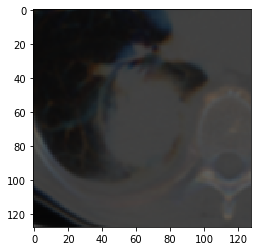

In [30]:
plt.imshow(train_x_re[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


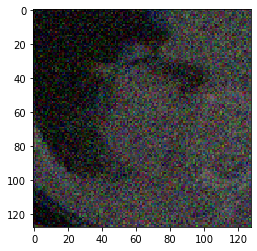

In [31]:
plt.imshow(train_x_noise_re[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


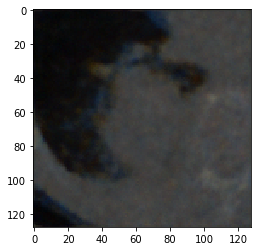

In [32]:
plt.imshow(train_output_re[0])

In [33]:
val_x_np = val_x.detach().cpu().numpy()
val_x_noise_np = val_x_noise.detach().cpu().numpy()
val_output_np = val_output.detach().cpu().numpy()

In [34]:
val_x_re = val_x_np.transpose(0, 2, 3, 1)
val_x_noise_re = val_x_noise_np.transpose(0, 2, 3, 1)
val_x_output_re = val_output_np.transpose(0, 2, 3, 1)

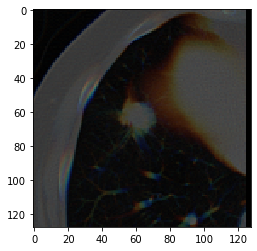

In [35]:
plt.imshow(val_x_re[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


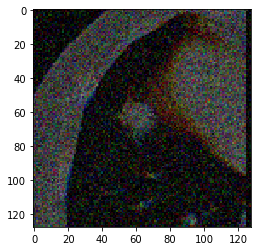

In [36]:
plt.imshow(val_x_noise_re[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


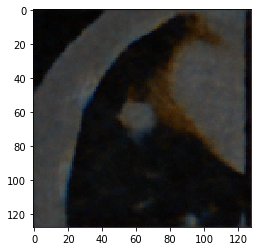

In [37]:
plt.imshow(val_x_output_re[0])

In [38]:
save_root = 'X:\\jechoi\\numpy\\Radiogenomics+genomics_raiomics_LAUD+LSCC'

In [39]:
np.save(save_root + '\\training_latent_variable_noBatchNorm.npy', train_latent_variable)
np.save(save_root + '\\training_latent_variable_stage_noBatchNorm.npy', train_label)
np.save(save_root + '\\validation_latent_variable_noBatchNorm.npy', val_latent_variable)
np.save(save_root + '\\validation_latent_variable_stage_noBatchNorm.npy', val_label)

In [40]:
torch.save(my_autoencoder.state_dict(), save_root + '/autoencoder_parm.pth')